# Plot for the Report 

In [8]:
# Libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
#Paths
DATA_PATH = "../data/"
IMG_PATH = "../data/images"
OUTPUT_DIR = "../docs/images_report"
os.makedirs(OUTPUT_DIR, exist_ok=True)

train_path = os.path.join(DATA_PATH,"train_augmented.csv")
dev_path   = os.path.join(DATA_PATH,"dev.csv")
test_path  = os.path.join(DATA_PATH,"test.csv")

#Load Data
df_train = pd.read_csv(train_path)
df_dev   = pd.read_csv(dev_path)
df_test  = pd.read_csv(test_path)

# Map labels to ints
stance_2id = {"oppose": 0, "support": 1}
pers_2id = {"no": 0, "yes": 1}

for df in [df_train, df_dev, df_test]:
    df["label"] = df["stance"].map(stance_2id)
    df["persuasiveness_label"] = df["persuasiveness"].map(pers_2id)

df_train.head()

,tweet_id,tweet_url,tweet_text,stance,persuasiveness,split,label,persuasiveness_label
0,1148501065308004357,https://t.co/VQP1FHaWAg,Let's McGyver some Sanity in America!\n\nYou a...,support,no,train,1,0
1,1103872992537276417,https://t.co/zsyXYSeBkp,A child deserves a chance at life. A child des...,oppose,no,train,0,0
2,1151528583623585794_aug,https://t.co/qSWvDX5MnM,"Dear prolifers: girls as young as 10, 11, 12 a...",support,no,train,1,0
3,1100166844026109953,https://t.co/hxH8tFIHUu,The many States will attempt to amend their co...,support,no,train,1,0
4,1021830413550067713,https://t.co/5whvEEtoQR,"Every #abortion is wrong, no matter what metho...",oppose,yes,train,0,1


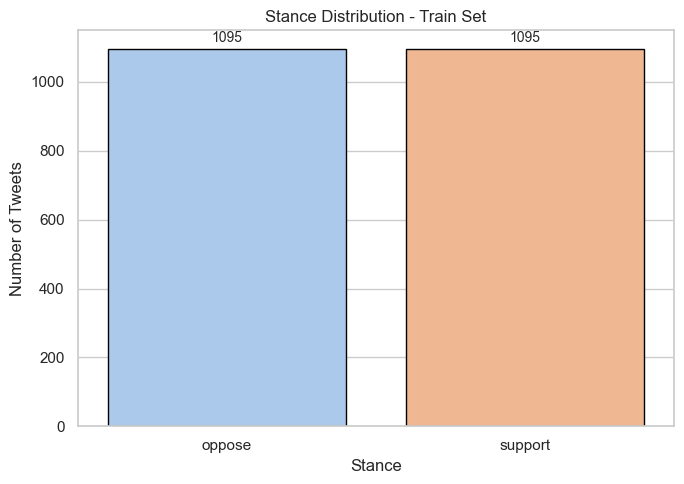

In [10]:
# Plot train set stance distribution
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 5))

ax = sns.countplot(data=df_train,x="stance",order=["oppose", "support"],
 palette="pastel",edgecolor="black",linewidth=1.0)
ax.set_title("Stance Distribution - Train Set")
ax.set_xlabel("Stance")
ax.set_ylabel("Number of Tweets")

# (Opcional) anotar conteos encima de cada barra
for p in ax.patches:
    h = p.get_height()
    ax.annotate(
        f"{int(h)}",
        (p.get_x() + p.get_width() / 2, h),
        ha="center",
        va="bottom",
        fontsize=10,
        xytext=(0, 3),
        textcoords="offset points"
    )

plt.tight_layout()

out_file = os.path.join(OUTPUT_DIR, "stance_distribution_train_augmented.png")
plt.savefig(out_file, dpi=200, bbox_inches="tight")
plt.show()

In [3]:
# Model Names
TEXT_MODEL_NAME = "microsoft/deberta-v3-base"  # 768 dims
BLIP_MODEL_NAME = "Salesforce/blip-itm-base-coco"  # 768 dims (vision encoder)
ALIGN_MODEL_NAME = "kakaobrain/align-base"  # Will project to 768 dims

# Text processing
MAX_TEXT_LENGTH = 128

# Common embedding dimension for fusion
COMMON_DIM = 768

print(f"Text Model: {TEXT_MODEL_NAME}")
print(f"BLIP Model: {BLIP_MODEL_NAME}")
print(f"ALIGN Model: {ALIGN_MODEL_NAME}")
print(f"Common embedding dimension: {COMMON_DIM}")

Text Model: microsoft/deberta-v3-base
BLIP Model: Salesforce/blip-itm-base-coco
ALIGN Model: kakaobrain/align-base
Common embedding dimension: 768


In [4]:
# Training hyperparameters
BATCH_SIZE = 16
NUM_EPOCHS = 15
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 1e-4
WARMUP_RATIO = 0.1

# Early stopping
PATIENCE = 5

# Number of classes
NUM_CLASSES = 2  

# Other
NUM_WORKERS = 1


print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Weight decay: {WEIGHT_DECAY}")
print(f"Warmup ratio: {WARMUP_RATIO}")
print(f"Patience: {PATIENCE}")

Batch size: 16
Epochs: 15
Learning rate: 2e-05
Weight decay: 0.0001
Warmup ratio: 0.1
Patience: 5


## BLIP Dataset

In [5]:
class MultimodalDatasetBLIP(Dataset):
    """
    Dataset for DeBERTa (text) + BLIP (vision) multimodal learning.
    
    Returns:
    - Tokenized text (input_ids, attention_mask) for DeBERTa
    - Processed image (pixel_values) for BLIP vision encoder
    - Label
    """
    def __init__(self, dataframe, img_dir, text_tokenizer, blip_processor, max_length=128):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.text_tokenizer = text_tokenizer
        self.blip_processor = blip_processor
        self.max_length = max_length
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Text 
        text = str(row['tweet_text'])
        text_encoding = self.text_tokenizer(text,max_length=self.max_length,padding='max_length',truncation=True,return_tensors='pt')
        
        # Load Image
        img_path = os.path.join(self.img_dir, str(row['tweet_id']) + ".jpg")
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            # fallback to grey image
            image = Image.new("RGB", (224, 224), color=(128, 128, 128))

        image_encoding = self.blip_processor(images=image, return_tensors='pt')
        
        # Label
        label = torch.tensor(row['label'], dtype=torch.long)
        
        return {
            'input_ids': text_encoding['input_ids'].squeeze(0),
            'attention_mask': text_encoding['attention_mask'].squeeze(0),
            'pixel_values': image_encoding['pixel_values'].squeeze(0),
            'label': label}

In [6]:
# Collate function for DataLoader
def collate_fn_blip(batch):
    """
    Custom collate function to handle batching.
    """
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'pixel_values': pixel_values,
        'labels': labels}

In [7]:
#Tokenizer and processor

# Text tokenizer (DeBERTa)
text_tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL_NAME)

# BLIP processor
blip_processor = BlipProcessor.from_pretrained(BLIP_MODEL_NAME)

print("Tokenizer and processor loaded successfully")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Tokenizer and processor loaded successfully


In [8]:
# Create datasets
train_dataset_blip = MultimodalDatasetBLIP(df_train, IMG_PATH, text_tokenizer, blip_processor, MAX_TEXT_LENGTH)
dev_dataset_blip = MultimodalDatasetBLIP(df_dev, IMG_PATH, text_tokenizer, blip_processor, MAX_TEXT_LENGTH)
test_dataset_blip = MultimodalDatasetBLIP(df_test, IMG_PATH, text_tokenizer, blip_processor, MAX_TEXT_LENGTH)

# Create dataloaders
train_loader_blip = DataLoader(train_dataset_blip,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn_blip)

dev_loader_blip = DataLoader(dev_dataset_blip,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn_blip)

test_loader_blip = DataLoader(test_dataset_blip,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn_blip)

print(f"Train batches: {len(train_loader_blip)}")
print(f"Dev batches: {len(dev_loader_blip)}")
print(f"Test batches: {len(test_loader_blip)}")

Train batches: 137
Dev batches: 13
Test batches: 19


In [9]:
# We test our dataloader
sample = train_dataset_blip[0]
print(f"Text input_ids shape: {sample['input_ids'].shape}")
print(f"Text attention_mask shape: {sample['attention_mask'].shape}")
print(f"Image pixel_values shape: {sample['pixel_values'].shape}")
print(f"Label: {sample['label']}")


Text input_ids shape: torch.Size([128])
Text attention_mask shape: torch.Size([128])
Image pixel_values shape: torch.Size([3, 384, 384])
Label: 1



# 1. DeBERTa + BLIP

In [10]:
class MultimodalBLIP(nn.Module):
    """
    Multimodal model combining DeBERTa (text) and BLIP (vision).
    
    Fusion strategies:
    - 'concat': Simple concatenation
    - 'mean': Average of embeddings
    - 'weighted_mean': Learnable weighted average
    - 'proj_concat': Project then concatenate
    - 'gated': Gated fusion mechanism
    """
    def __init__(
        self,
        text_model_name="microsoft/deberta-v3-base",
        vision_model_name="Salesforce/blip-itm-base-coco",
        num_classes=2,
        fusion_type="concat",
        common_dim=768,
        dropout=0.1,
        freeze_text=False,
        freeze_vision=False
    ):
        super(MultimodalBLIP, self).__init__()
        
        self.fusion_type = fusion_type
        self.common_dim = common_dim
        
        # Text encoder: DeBERTa
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        self.text_dim = self.text_encoder.config.hidden_size  # 768
        
        # Vision encoder: BLIP (only vision part)
        blip_full = BlipModel.from_pretrained(vision_model_name)
        self.vision_encoder = blip_full.vision_model  # Extract only vision encoder
        self.vision_dim = blip_full.config.vision_config.hidden_size  # 768
        
        # Freeze encoders if specified
        if freeze_text:
            for param in self.text_encoder.parameters():
                param.requires_grad = False
        
        if freeze_vision:
            for param in self.vision_encoder.parameters():
                param.requires_grad = False
        
        # Projection layers (if needed)
        if self.text_dim != common_dim:
            self.text_projection = nn.Linear(self.text_dim, common_dim)
        else:
            self.text_projection = nn.Identity()
        
        if self.vision_dim != common_dim:
            self.vision_projection = nn.Linear(self.vision_dim, common_dim)
        else:
            self.vision_projection = nn.Identity()
        
        # Fusion layers
        if fusion_type == "concat":
            fusion_dim = common_dim * 2
            self.fusion_layer = nn.Sequential(
                nn.Linear(fusion_dim, common_dim),
                nn.ReLU(),
                nn.Dropout(dropout))
        
        elif fusion_type == "mean":
            fusion_dim = common_dim
            self.fusion_layer = nn.Identity()
        
        elif fusion_type == "weighted_mean":
            fusion_dim = common_dim
            # Learnable weights for weighted average
            self.text_weight = nn.Parameter(torch.tensor(0.5))
            self.vision_weight = nn.Parameter(torch.tensor(0.5))
            self.fusion_layer = nn.Identity()
        
        elif fusion_type == "proj_concat":
            # Project to lower dim, then concatenate
            proj_dim = common_dim // 2
            self.text_proj = nn.Linear(common_dim, proj_dim)
            self.vision_proj = nn.Linear(common_dim, proj_dim)
            fusion_dim = proj_dim * 2
            self.fusion_layer = nn.Sequential(
                nn.Linear(fusion_dim, common_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
        
        elif fusion_type == "gated":
            fusion_dim = common_dim
            # Gate mechanism
            self.gate = nn.Sequential(
                nn.Linear(common_dim * 2, common_dim),
                nn.Sigmoid()
            )
            self.fusion_layer = nn.Identity()
        
        else:
            raise ValueError(f"Unknown fusion type: {fusion_type}")
        
        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(common_dim, common_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(common_dim // 2, num_classes)
        )
    
    def forward(self, input_ids, attention_mask, pixel_values):

        # Text embeddings
        text_outputs = self.text_encoder(input_ids=input_ids,attention_mask=attention_mask)
        text_emb = text_outputs.last_hidden_state[:, 0, :]  # [CLS] token
        text_emb = self.text_projection(text_emb)  # Project to common_dim
        
        # Vision emgeddings
        vision_outputs = self.vision_encoder(pixel_values=pixel_values)
        # BLIP vision encoder returns BaseModelOutputWithPooling
        # We can use pooler_output or last_hidden_state[:, 0, :]
        vision_emb = vision_outputs.pooler_output  # Already pooled
        vision_emb = self.vision_projection(vision_emb)  # Project to common_dim
        
        # Fusion
        if self.fusion_type == "concat":
            fused = torch.cat([text_emb, vision_emb], dim=1)
            fused = self.fusion_layer(fused)
        
        elif self.fusion_type == "mean":
            fused = (text_emb + vision_emb) / 2
        
        elif self.fusion_type == "weighted_mean":
            # Normalize weights
            w_text = torch.sigmoid(self.text_weight)
            w_vision = torch.sigmoid(self.vision_weight)
            total = w_text + w_vision
            fused = (w_text / total) * text_emb + (w_vision / total) * vision_emb
        
        elif self.fusion_type == "proj_concat":
            text_proj = self.text_proj(text_emb)
            vision_proj = self.vision_proj(vision_emb)
            fused = torch.cat([text_proj, vision_proj], dim=1)
            fused = self.fusion_layer(fused)
        
        elif self.fusion_type == "gated":
            # Gate decides how much of each modality to use
            concat = torch.cat([text_emb, vision_emb], dim=1)
            gate = self.gate(concat)
            fused = gate * text_emb + (1 - gate) * vision_emb
        
        # Classification
        logits = self.classifier(fused)
        
        return logits

#### Sanity Check (Forward)

In [11]:
# Test all fusion types
fusion_types = ["concat", "mean", "weighted_mean", "proj_concat", "gated"]

for fusion in fusion_types:
    print(f"Fusion: {fusion}")
    model = MultimodalBLIP(
        text_model_name=TEXT_MODEL_NAME,
        vision_model_name=BLIP_MODEL_NAME,
        num_classes=NUM_CLASSES,
        fusion_type=fusion,
        common_dim=COMMON_DIM).to(DEVICE)
    
    # Get a batch
    batch = next(iter(train_loader_blip))
    input_ids = batch['input_ids'][:4].to(DEVICE)
    attention_mask = batch['attention_mask'][:4].to(DEVICE)
    pixel_values = batch['pixel_values'][:4].to(DEVICE)
    
    # Forward pass
    with torch.no_grad():
        logits = model(input_ids, attention_mask, pixel_values)
    
    print(f"  Input batch size: {input_ids.size(0)}")
    print(f"  Output logits shape: {logits.shape}")
    print(f"  Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print()
    
    # Clean up
    del model
    torch.cuda.empty_cache()


Fusion: concat


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

  Input batch size: 4
  Output logits shape: torch.Size([4, 2])
  Model parameters: 271,398,530
  Trainable parameters: 271,398,530

Fusion: mean


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

  Input batch size: 4
  Output logits shape: torch.Size([4, 2])
  Model parameters: 270,218,114
  Trainable parameters: 270,218,114

Fusion: weighted_mean


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

  Input batch size: 4
  Output logits shape: torch.Size([4, 2])
  Model parameters: 270,218,116
  Trainable parameters: 270,218,116

Fusion: proj_concat


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

  Input batch size: 4
  Output logits shape: torch.Size([4, 2])
  Model parameters: 271,399,298
  Trainable parameters: 271,399,298

Fusion: gated


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

  Input batch size: 4
  Output logits shape: torch.Size([4, 2])
  Model parameters: 271,398,530
  Trainable parameters: 271,398,530



### Training Function

In [12]:
def train_multimodal_model(
    model,
    train_loader,
    dev_loader,
    num_epochs=15,
    learning_rate=2e-5,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    patience=5,
    device=DEVICE,
    save_path=None
):
    """
    Train multimodal model with early stopping.
    
    Returns:
        best_model: Best model based on dev F1-score
        history: Training history
    """
    model = model.to(device)
    
    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
    
    # Scheduler
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(total_steps * warmup_ratio)
    scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=warmup_steps,num_training_steps=total_steps)
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Training history
    history = {
        'train_loss': [],
        'dev_loss': [],
        'dev_f1': [],
        'dev_acc': []
    }
    
    # Early stopping
    best_f1 = 0.0
    patience_counter = 0
    best_model_state = None
    
    print(f"Starting training for {num_epochs} epochs...")
    print(f"Total steps: {total_steps}, Warmup steps: {warmup_steps}\n")
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            
            logits = model(input_ids, attention_mask, pixel_values)
            loss = criterion(logits, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
        
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        # Validation
        model.eval()
        dev_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in dev_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                pixel_values = batch['pixel_values'].to(device)
                labels = batch['labels'].to(device)
                
                logits = model(input_ids, attention_mask, pixel_values)
                loss = criterion(logits, labels)
                
                dev_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_dev_loss = dev_loss / len(dev_loader)
        
        # Metrics (F1-score binary with pos_label=1)
        dev_acc = accuracy_score(all_labels, all_preds)
        _, _, dev_f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary', pos_label=1, zero_division=0)
        
        history['dev_loss'].append(avg_dev_loss)
        history['dev_f1'].append(dev_f1)
        history['dev_acc'].append(dev_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Dev Loss: {avg_dev_loss:.4f}")
        print(f"  Dev Accuracy: {dev_acc:.4f}")
        print(f"  Dev F1 (binary, pos=1): {dev_f1:.4f}")
        
        # Early stopping check
        if dev_f1 > best_f1:
            best_f1 = dev_f1
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f"    New best F1: {best_f1:.4f}")
            
            if save_path:
                torch.save(best_model_state, save_path)
        else:
            patience_counter += 1
            print(f"  Patience: {patience_counter}/{patience}")
        
        print()
        
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    print(f"Training completed. Best Dev F1: {best_f1:.4f}")
    
    return model, history

### Evaluation Function

In [13]:
def evaluate_multimodal_model(model, test_loader, device=DEVICE):
    """
    Evaluate model on test set.
    
    Returns:
        metrics: Dictionary with accuracy, F1, precision, recall
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            logits = model(input_ids, attention_mask, pixel_values)
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
        metrics = {
        "accuracy": accuracy_score(all_labels, all_preds),
        "f1": f1_score(all_labels, all_preds, average="binary", pos_label=1, zero_division=0),
        "precision": precision_score(all_labels, all_preds, pos_label=1, zero_division=0),
        "recall": recall_score(all_labels, all_preds, pos_label=1, zero_division=0),
        "report": classification_report(all_labels, all_preds, zero_division=0)
    }

    # Print results
    print("\nTEST RESULTS")
    print(f"  Accuracy : {metrics['accuracy']:.4f}")
    print(f"  F1-score : {metrics['f1']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall   : {metrics['recall']:.4f}")

    # Confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    return metrics

    


### Training & Testing

In [ ]:
# Results storage
results_blip = []

fusion_strategies = ["concat", "mean", "weighted_mean", "proj_concat", "gated"]


print("TRAINING ALL FUSION STRATEGIES: DeBERTa + BLIP")
print(f"Fusion strategies: {fusion_strategies}\n")

for fusion in fusion_strategies:
    print("\n" + "#"*80)
    print(f"FUSION STRATEGY: {fusion.upper()}")
    print("#"*80 + "\n")
    
    # Initialize model
    model = MultimodalBLIP(
        text_model_name=TEXT_MODEL_NAME,
        vision_model_name=BLIP_MODEL_NAME,
        num_classes=NUM_CLASSES,
        fusion_type=fusion,
        common_dim=COMMON_DIM,
        dropout=0.1
    )
    
    # Train
    save_path = os.path.join(OUTPUT_DIR, f"deberta_blip_{fusion}_best.pt")
    trained_model, history = train_multimodal_model(
        model=model,
        train_loader=train_loader_blip,
        dev_loader=dev_loader_blip,
        num_epochs=NUM_EPOCHS,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        warmup_ratio=WARMUP_RATIO,
        patience=PATIENCE,
        save_path=save_path
    )
    
    # Evaluate on test set
    print(f"\n{'='*70}")
    print(f"EVALUATING {fusion.upper()} ON TEST SET")
    print(f"{'='*70}")
    
    test_metrics = evaluate_multimodal_model(trained_model, test_loader_blip)
    
    # Store results
    results_blip.append({
        'model': 'DeBERTa + BLIP',
        'fusion': fusion,
        'accuracy': test_metrics['accuracy'],
        'f1': test_metrics['f1'],
        'precision': test_metrics['precision'],
        'recall': test_metrics['recall'],
        'best_dev_f1': max(history['dev_f1'])
    })
    


    # Clean up
    del model, trained_model
    torch.cuda.empty_cache()
    
    print(f"\n{'='*70}\n")

In [ ]:
# Create results DataFrame
df_results_blip = pd.DataFrame(results_blip)
df_results_blip = df_results_blip.sort_values('f1', ascending=False)
print("RESULTS SUMMARY: DeBERTa + BLIP")
print(df_results_blip.to_string(index=False))

# Save results
df_results_blip.to_csv(os.path.join(OUTPUT_DIR, "results_deberta_blip.csv"), index=False)
print(f"\n Results saved to: {os.path.join(OUTPUT_DIR, 'results_deberta_blip.csv')}")

## 2. DeBERTa + ALIGN

In [14]:
class MultimodalDatasetALIGN(Dataset):
    """
    Dataset for DeBERTa (text) + ALIGN (vision) multimodal learning.
    
    Returns:
    - Tokenized text (input_ids, attention_mask) for DeBERTa
    - Processed image (pixel_values) for ALIGN vision encoder
    - Label
    """
    def __init__(self, dataframe, img_dir, text_tokenizer, align_processor, max_length=128):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.text_tokenizer = text_tokenizer
        self.align_processor = align_processor
        self.max_length = max_length
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Text
        text = str(row['tweet_text'])
        text_encoding = self.text_tokenizer(text,max_length=self.max_length,padding='max_length',truncation=True,return_tensors='pt')

    
        # Load Image - ALIGN PROCESSOR
        img_path = os.path.join(self.img_dir, str(row['tweet_id']) + ".jpg")
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new("RGB", (289, 289), color=(128, 128, 128))
        
        image_encoding = self.align_processor(images=image, return_tensors='pt')
        
        # Label
        label = torch.tensor(row['label'], dtype=torch.long)
        
        return {
            'input_ids': text_encoding['input_ids'].squeeze(0),
            'attention_mask': text_encoding['attention_mask'].squeeze(0),
            'pixel_values': image_encoding['pixel_values'].squeeze(0),
            'label': label
        }

In [15]:
# Collate function for ALIGN DataLoader (same as BLIP)
def collate_fn_align(batch):
    """
    Custom collate function to handle batching.
    """
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'pixel_values': pixel_values,
        'labels': labels
    }

In [16]:
# ALIGN processor
align_processor = AlignProcessor.from_pretrained(ALIGN_MODEL_NAME)

print(" ALIGN processor loaded successfully")

 ALIGN processor loaded successfully


In [17]:
# Create datasets
train_dataset_align = MultimodalDatasetALIGN(df_train, IMG_PATH, text_tokenizer, align_processor, MAX_TEXT_LENGTH)
dev_dataset_align = MultimodalDatasetALIGN(df_dev, IMG_PATH, text_tokenizer, align_processor, MAX_TEXT_LENGTH)
test_dataset_align = MultimodalDatasetALIGN(df_test, IMG_PATH, text_tokenizer, align_processor, MAX_TEXT_LENGTH)

# Create dataloaders
train_loader_align = DataLoader(train_dataset_align,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn_align)
dev_loader_align = DataLoader(dev_dataset_align,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn_align)
test_loader_align = DataLoader(test_dataset_align,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn_align)

print(f"Train batches: {len(train_loader_align)}")
print(f"Dev batches: {len(dev_loader_align)}")
print(f"Test batches: {len(test_loader_align)}")

Train batches: 137
Dev batches: 13
Test batches: 19


In [18]:
# We test our dataloader
sample = train_dataset_align[0]
print(f"Text input_ids shape: {sample['input_ids'].shape}")
print(f"Text attention_mask shape: {sample['attention_mask'].shape}")
print(f"Image pixel_values shape: {sample['pixel_values'].shape}")
print(f"Label: {sample['label']}")

Text input_ids shape: torch.Size([128])
Text attention_mask shape: torch.Size([128])
Image pixel_values shape: torch.Size([3, 289, 289])
Label: 1


In [19]:
class MultimodalALIGN(nn.Module):
    """
    Multimodal model combining DeBERTa (text) and ALIGN (vision).
    
    Fusion strategies:
    - 'concat': Simple concatenation
    - 'mean': Average of embeddings
    - 'weighted_mean': Learnable weighted average
    - 'proj_concat': Project then concatenate
    - 'gated': Gated fusion mechanism
    """
    def __init__(
        self,
        text_model_name="microsoft/deberta-v3-base",
        vision_model_name="kakaobrain/align-base",
        num_classes=3,
        fusion_type="concat",
        common_dim=768,
        dropout=0.1,
        freeze_text=False,
        freeze_vision=False
    ):
        super(MultimodalALIGN, self).__init__()
        
        self.fusion_type = fusion_type
        self.common_dim = common_dim
        
        # Text encoder: DeBERTa
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        self.text_dim = self.text_encoder.config.hidden_size  # 768
        
        # Vision encoder: ALIGN (only vision part)
        align_full = AlignModel.from_pretrained(vision_model_name)
        self.vision_encoder = align_full.vision_model  # Extract only vision encoder
        self.vision_dim = align_full.config.vision_config.hidden_dim #640
        
        print(f"ALIGN vision dimension: {self.vision_dim}")
        
        # Freeze encoders if specified
        if freeze_text:
            for param in self.text_encoder.parameters():
                param.requires_grad = False
        
        if freeze_vision:
            for param in self.vision_encoder.parameters():
                param.requires_grad = False
        
        # Projection layers to common dimension
        if self.text_dim != common_dim:
            self.text_projection = nn.Linear(self.text_dim, common_dim)
        else:
            self.text_projection = nn.Identity()
        
        # ALIGN vision encoder output needs projection
        if self.vision_dim != common_dim:
            self.vision_projection = nn.Linear(self.vision_dim, common_dim)
        else:
            self.vision_projection = nn.Identity()
        
        # Fusion-specific layers (same as BLIP model)
        if fusion_type == "concat":
            fusion_dim = common_dim * 2
            self.fusion_layer = nn.Sequential(
                nn.Linear(fusion_dim, common_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
        
        elif fusion_type == "mean":
            fusion_dim = common_dim
            self.fusion_layer = nn.Identity()
        
        elif fusion_type == "weighted_mean":
            fusion_dim = common_dim
            # Learnable weights for weighted average
            self.text_weight = nn.Parameter(torch.tensor(0.5))
            self.vision_weight = nn.Parameter(torch.tensor(0.5))
            self.fusion_layer = nn.Identity()
        
        elif fusion_type == "proj_concat":
            # Project to lower dim, then concatenate
            proj_dim = common_dim // 2
            self.text_proj = nn.Linear(common_dim, proj_dim)
            self.vision_proj = nn.Linear(common_dim, proj_dim)
            fusion_dim = proj_dim * 2
            self.fusion_layer = nn.Sequential(
                nn.Linear(fusion_dim, common_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
        
        elif fusion_type == "gated":
            fusion_dim = common_dim
            # Gate mechanism
            self.gate = nn.Sequential(
                nn.Linear(common_dim * 2, common_dim),
                nn.Sigmoid()
            )
            self.fusion_layer = nn.Identity()
        
        else:
            raise ValueError(f"Unknown fusion type: {fusion_type}")
        
        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(common_dim, common_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(common_dim // 2, num_classes)
        )
    
    def forward(self, input_ids, attention_mask, pixel_values):
        
        # Text Embeddings 
        text_outputs = self.text_encoder(input_ids=input_ids,attention_mask=attention_mask)
        text_emb = text_outputs.last_hidden_state[:, 0, :]  # [CLS] token
        text_emb = self.text_projection(text_emb)  # Project to common_dim
        
        # Vision Embeddings
        vision_outputs = self.vision_encoder(pixel_values=pixel_values)
        # ALIGN vision encoder returns BaseModelOutputWithPooling
        vision_emb = vision_outputs.pooler_output  # Already pooled
        vision_emb = self.vision_projection(vision_emb)  # Project to common_dim
        
        # Fusion
        if self.fusion_type == "concat":
            fused = torch.cat([text_emb, vision_emb], dim=1)
            fused = self.fusion_layer(fused)
        
        elif self.fusion_type == "mean":
            fused = (text_emb + vision_emb) / 2
        
        elif self.fusion_type == "weighted_mean":
            # Normalize weights
            w_text = torch.sigmoid(self.text_weight)
            w_vision = torch.sigmoid(self.vision_weight)
            total = w_text + w_vision
            fused = (w_text / total) * text_emb + (w_vision / total) * vision_emb
        
        elif self.fusion_type == "proj_concat":
            text_proj = self.text_proj(text_emb)
            vision_proj = self.vision_proj(vision_emb)
            fused = torch.cat([text_proj, vision_proj], dim=1)
            fused = self.fusion_layer(fused)
        
        elif self.fusion_type == "gated":
            concat = torch.cat([text_emb, vision_emb], dim=1)
            gate = self.gate(concat)
            fused = gate * text_emb + (1 - gate) * vision_emb
        
        logits = self.classifier(fused)
        
        return logits

In [20]:
#Sanity check for ALIGN model and fusion strategies
fusion_types = ["concat", "mean", "weighted_mean", "proj_concat", "gated"]
for fusion in fusion_types:
    print(f"Fusion: {fusion}")
    model = MultimodalALIGN(
        text_model_name=TEXT_MODEL_NAME,
        vision_model_name=ALIGN_MODEL_NAME,
        num_classes=NUM_CLASSES,
        fusion_type=fusion,
        common_dim=COMMON_DIM).to(DEVICE)
    
    batch = next(iter(train_loader_align))
    input_ids = batch['input_ids'][:4].to(DEVICE)
    attention_mask = batch['attention_mask'][:4].to(DEVICE)
    pixel_values = batch['pixel_values'][:4].to(DEVICE)
    
    with torch.no_grad():
        logits = model(input_ids, attention_mask, pixel_values)
    
    print(f"  Input batch size: {input_ids.size(0)}")
    print(f"  Output logits shape: {logits.shape}")
    print(f"  Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print()
    
    # Clean up
    del model
    torch.cuda.empty_cache()

Fusion: concat
ALIGN vision dimension: 640
  Input batch size: 4
  Output logits shape: torch.Size([4, 2])
  Model parameters: 247,943,762
  Trainable parameters: 247,943,762

Fusion: mean
ALIGN vision dimension: 640
  Input batch size: 4
  Output logits shape: torch.Size([4, 2])
  Model parameters: 246,763,346
  Trainable parameters: 246,763,346

Fusion: weighted_mean
ALIGN vision dimension: 640
  Input batch size: 4
  Output logits shape: torch.Size([4, 2])
  Model parameters: 246,763,348
  Trainable parameters: 246,763,348

Fusion: proj_concat
ALIGN vision dimension: 640
  Input batch size: 4
  Output logits shape: torch.Size([4, 2])
  Model parameters: 247,944,530
  Trainable parameters: 247,944,530

Fusion: gated
ALIGN vision dimension: 640
  Input batch size: 4
  Output logits shape: torch.Size([4, 2])
  Model parameters: 247,943,762
  Trainable parameters: 247,943,762



In [22]:
# Results storage
results_align = []

fusion_strategies = ["concat", "mean", "weighted_mean", "proj_concat", "gated"]

print("="*70)
print("TRAINING ALL FUSION STRATEGIES: DeBERTa + ALIGN")
print("="*70)
print(f"Fusion strategies: {fusion_strategies}\n")

for fusion in fusion_strategies:
    print("\n" + "#"*70)
    print(f"FUSION STRATEGY: {fusion.upper()}")
    print("#"*70 + "\n")
    
    # Initialize model
    model = MultimodalALIGN(
        text_model_name=TEXT_MODEL_NAME,
        vision_model_name=ALIGN_MODEL_NAME,
        num_classes=NUM_CLASSES,
        fusion_type=fusion,
        common_dim=COMMON_DIM,
        dropout=0.1
    )
    
    # Train
    save_path = os.path.join(OUTPUT_DIR, f"deberta_align_{fusion}_best.pt")
    trained_model, history = train_multimodal_model(
        model=model,
        train_loader=train_loader_align,
        dev_loader=dev_loader_align,
        num_epochs=NUM_EPOCHS,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        warmup_ratio=WARMUP_RATIO,
        patience=PATIENCE,
        save_path=save_path
    )
    
    # Evaluate on test set
    print(f"\n{'='*70}")
    print(f"EVALUATING {fusion.upper()} ON TEST SET")
    print(f"{'='*70}")
    
    test_metrics = evaluate_multimodal_model(trained_model, test_loader_align)
    
    # Store results
    results_align.append({
        'model': 'DeBERTa + ALIGN',
        'fusion': fusion,
        'accuracy': test_metrics['accuracy'],
        'f1': test_metrics['f1'],
        'precision': test_metrics['precision'],
        'recall': test_metrics['recall'],
        'best_dev_f1': max(history['dev_f1'])
    })
    


    # Clean up
    del model, trained_model
    torch.cuda.empty_cache()
    
    print(f"\n{'='*70}\n")

TRAINING ALL FUSION STRATEGIES: DeBERTa + ALIGN
Fusion strategies: ['concat', 'mean', 'weighted_mean', 'proj_concat', 'gated']


######################################################################
FUSION STRATEGY: CONCAT
######################################################################

ALIGN vision dimension: 640
Starting training for 15 epochs...
Total steps: 2055, Warmup steps: 205



Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 1/15:
  Train Loss: 0.6323
  Dev Loss: 0.4504
  Dev Accuracy: 0.8200
  Dev F1 (binary, pos=1): 0.6897
    New best F1: 0.6897



Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:
  Train Loss: 0.3573
  Dev Loss: 0.2900
  Dev Accuracy: 0.8850
  Dev F1 (binary, pos=1): 0.8497
    New best F1: 0.8497



Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:
  Train Loss: 0.2304
  Dev Loss: 0.2778
  Dev Accuracy: 0.9000
  Dev F1 (binary, pos=1): 0.8551
    New best F1: 0.8551



Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:
  Train Loss: 0.1318
  Dev Loss: 0.3991
  Dev Accuracy: 0.8850
  Dev F1 (binary, pos=1): 0.8296
  Patience: 1/5



Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:
  Train Loss: 0.0622
  Dev Loss: 0.4114
  Dev Accuracy: 0.8950
  Dev F1 (binary, pos=1): 0.8421
  Patience: 2/5



Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:
  Train Loss: 0.0206
  Dev Loss: 0.7859
  Dev Accuracy: 0.8700
  Dev F1 (binary, pos=1): 0.7937
  Patience: 3/5



Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:
  Train Loss: 0.0102
  Dev Loss: 0.5532
  Dev Accuracy: 0.9050
  Dev F1 (binary, pos=1): 0.8671
    New best F1: 0.8671



Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:
  Train Loss: 0.0133
  Dev Loss: 0.6751
  Dev Accuracy: 0.8850
  Dev F1 (binary, pos=1): 0.8296
  Patience: 1/5



Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:
  Train Loss: 0.0042
  Dev Loss: 0.7512
  Dev Accuracy: 0.8950
  Dev F1 (binary, pos=1): 0.8421
  Patience: 2/5



Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:
  Train Loss: 0.0066
  Dev Loss: 0.6753
  Dev Accuracy: 0.9100
  Dev F1 (binary, pos=1): 0.8696
    New best F1: 0.8696



Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:
  Train Loss: 0.0019
  Dev Loss: 0.7492
  Dev Accuracy: 0.9050
  Dev F1 (binary, pos=1): 0.8593
  Patience: 1/5



Epoch 12/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12/15:
  Train Loss: 0.0065
  Dev Loss: 0.7967
  Dev Accuracy: 0.8950
  Dev F1 (binary, pos=1): 0.8421
  Patience: 2/5



Epoch 13/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13/15:
  Train Loss: 0.0048
  Dev Loss: 0.7805
  Dev Accuracy: 0.8950
  Dev F1 (binary, pos=1): 0.8421
  Patience: 3/5



Epoch 14/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 14/15:
  Train Loss: 0.0007
  Dev Loss: 0.7136
  Dev Accuracy: 0.9050
  Dev F1 (binary, pos=1): 0.8613
  Patience: 4/5



Epoch 15/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 15/15:
  Train Loss: 0.0006
  Dev Loss: 0.7016
  Dev Accuracy: 0.9050
  Dev F1 (binary, pos=1): 0.8633
  Patience: 5/5

Early stopping triggered after 15 epochs
Training completed. Best Dev F1: 0.8696

EVALUATING CONCAT ON TEST SET


Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]


TEST RESULTS
  Accuracy : 0.8400
  F1-score : 0.8195
  Precision: 0.7365
  Recall   : 0.9237

Confusion Matrix:
[[143  39]
 [  9 109]]



######################################################################
FUSION STRATEGY: MEAN
######################################################################

ALIGN vision dimension: 640
Starting training for 15 epochs...
Total steps: 2055, Warmup steps: 205



Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 1/15:
  Train Loss: 0.6230
  Dev Loss: 0.4651
  Dev Accuracy: 0.8700
  Dev F1 (binary, pos=1): 0.8000
    New best F1: 0.8000



Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:
  Train Loss: 0.3372
  Dev Loss: 0.3076
  Dev Accuracy: 0.8800
  Dev F1 (binary, pos=1): 0.8462
    New best F1: 0.8462



Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:
  Train Loss: 0.1875
  Dev Loss: 0.2434
  Dev Accuracy: 0.9200
  Dev F1 (binary, pos=1): 0.8824
    New best F1: 0.8824



Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:
  Train Loss: 0.1013
  Dev Loss: 0.3748
  Dev Accuracy: 0.9100
  Dev F1 (binary, pos=1): 0.8615
  Patience: 1/5



Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:
  Train Loss: 0.0635
  Dev Loss: 0.3809
  Dev Accuracy: 0.9050
  Dev F1 (binary, pos=1): 0.8613
  Patience: 2/5



Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:
  Train Loss: 0.0306
  Dev Loss: 0.4160
  Dev Accuracy: 0.9250
  Dev F1 (binary, pos=1): 0.8966
    New best F1: 0.8966



Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:
  Train Loss: 0.0151
  Dev Loss: 0.4943
  Dev Accuracy: 0.9050
  Dev F1 (binary, pos=1): 0.8652
  Patience: 1/5



Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:
  Train Loss: 0.0198
  Dev Loss: 0.5397
  Dev Accuracy: 0.9150
  Dev F1 (binary, pos=1): 0.8741
  Patience: 2/5



Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:
  Train Loss: 0.0128
  Dev Loss: 0.6081
  Dev Accuracy: 0.9100
  Dev F1 (binary, pos=1): 0.8657
  Patience: 3/5



Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:
  Train Loss: 0.0119
  Dev Loss: 0.5884
  Dev Accuracy: 0.8950
  Dev F1 (binary, pos=1): 0.8489
  Patience: 4/5



Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:
  Train Loss: 0.0103
  Dev Loss: 0.6292
  Dev Accuracy: 0.9050
  Dev F1 (binary, pos=1): 0.8613
  Patience: 5/5

Early stopping triggered after 11 epochs
Training completed. Best Dev F1: 0.8966

EVALUATING MEAN ON TEST SET


Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]


TEST RESULTS
  Accuracy : 0.8567
  F1-score : 0.8340
  Precision: 0.7660
  Recall   : 0.9153

Confusion Matrix:
[[149  33]
 [ 10 108]]



######################################################################
FUSION STRATEGY: WEIGHTED_MEAN
######################################################################

ALIGN vision dimension: 640
Starting training for 15 epochs...
Total steps: 2055, Warmup steps: 205



Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 1/15:
  Train Loss: 0.6223
  Dev Loss: 0.4865
  Dev Accuracy: 0.8050
  Dev F1 (binary, pos=1): 0.6355
    New best F1: 0.6355



Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:
  Train Loss: 0.3470
  Dev Loss: 0.2569
  Dev Accuracy: 0.9100
  Dev F1 (binary, pos=1): 0.8594
    New best F1: 0.8594



Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:
  Train Loss: 0.2172
  Dev Loss: 0.2955
  Dev Accuracy: 0.8750
  Dev F1 (binary, pos=1): 0.8322
  Patience: 1/5



Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:
  Train Loss: 0.1269
  Dev Loss: 0.3729
  Dev Accuracy: 0.9000
  Dev F1 (binary, pos=1): 0.8462
  Patience: 2/5



Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:
  Train Loss: 0.0815
  Dev Loss: 0.4067
  Dev Accuracy: 0.9000
  Dev F1 (binary, pos=1): 0.8529
  Patience: 3/5



Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:
  Train Loss: 0.0386
  Dev Loss: 0.3855
  Dev Accuracy: 0.9100
  Dev F1 (binary, pos=1): 0.8696
    New best F1: 0.8696



Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:
  Train Loss: 0.0257
  Dev Loss: 0.5063
  Dev Accuracy: 0.9050
  Dev F1 (binary, pos=1): 0.8550
  Patience: 1/5



Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:
  Train Loss: 0.0142
  Dev Loss: 0.5189
  Dev Accuracy: 0.9050
  Dev F1 (binary, pos=1): 0.8571
  Patience: 2/5



Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:
  Train Loss: 0.0136
  Dev Loss: 0.6035
  Dev Accuracy: 0.9000
  Dev F1 (binary, pos=1): 0.8485
  Patience: 3/5



Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:
  Train Loss: 0.0060
  Dev Loss: 0.5532
  Dev Accuracy: 0.9100
  Dev F1 (binary, pos=1): 0.8657
  Patience: 4/5



Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:
  Train Loss: 0.0052
  Dev Loss: 0.5578
  Dev Accuracy: 0.9100
  Dev F1 (binary, pos=1): 0.8657
  Patience: 5/5

Early stopping triggered after 11 epochs
Training completed. Best Dev F1: 0.8696

EVALUATING WEIGHTED_MEAN ON TEST SET


Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]


TEST RESULTS
  Accuracy : 0.8433
  F1-score : 0.8240
  Precision: 0.7383
  Recall   : 0.9322

Confusion Matrix:
[[143  39]
 [  8 110]]



######################################################################
FUSION STRATEGY: PROJ_CONCAT
######################################################################

ALIGN vision dimension: 640
Starting training for 15 epochs...
Total steps: 2055, Warmup steps: 205



Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 1/15:
  Train Loss: 0.6641
  Dev Loss: 0.5024
  Dev Accuracy: 0.8250
  Dev F1 (binary, pos=1): 0.7742
    New best F1: 0.7742



Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:
  Train Loss: 0.3096
  Dev Loss: 0.3933
  Dev Accuracy: 0.8400
  Dev F1 (binary, pos=1): 0.7193
  Patience: 1/5



Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:
  Train Loss: 0.1624
  Dev Loss: 0.3749
  Dev Accuracy: 0.9050
  Dev F1 (binary, pos=1): 0.8707
    New best F1: 0.8707



Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:
  Train Loss: 0.0903
  Dev Loss: 0.3636
  Dev Accuracy: 0.9200
  Dev F1 (binary, pos=1): 0.8788
    New best F1: 0.8788



Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:
  Train Loss: 0.0377
  Dev Loss: 0.5744
  Dev Accuracy: 0.9000
  Dev F1 (binary, pos=1): 0.8507
  Patience: 1/5



Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:
  Train Loss: 0.0169
  Dev Loss: 0.6069
  Dev Accuracy: 0.9050
  Dev F1 (binary, pos=1): 0.8613
  Patience: 2/5



Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:
  Train Loss: 0.0080
  Dev Loss: 0.8498
  Dev Accuracy: 0.8750
  Dev F1 (binary, pos=1): 0.8031
  Patience: 3/5



Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:
  Train Loss: 0.0106
  Dev Loss: 0.7178
  Dev Accuracy: 0.8950
  Dev F1 (binary, pos=1): 0.8444
  Patience: 4/5



Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:
  Train Loss: 0.0032
  Dev Loss: 0.7283
  Dev Accuracy: 0.9050
  Dev F1 (binary, pos=1): 0.8593
  Patience: 5/5

Early stopping triggered after 9 epochs
Training completed. Best Dev F1: 0.8788

EVALUATING PROJ_CONCAT ON TEST SET


Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]


TEST RESULTS
  Accuracy : 0.8733
  F1-score : 0.8516
  Precision: 0.7899
  Recall   : 0.9237

Confusion Matrix:
[[153  29]
 [  9 109]]



######################################################################
FUSION STRATEGY: GATED
######################################################################

ALIGN vision dimension: 640
Starting training for 15 epochs...
Total steps: 2055, Warmup steps: 205



Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 1/15:
  Train Loss: 0.6553
  Dev Loss: 0.5548
  Dev Accuracy: 0.7400
  Dev F1 (binary, pos=1): 0.5185
    New best F1: 0.5185



Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:
  Train Loss: 0.3093
  Dev Loss: 0.3310
  Dev Accuracy: 0.8950
  Dev F1 (binary, pos=1): 0.8372
    New best F1: 0.8372



Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:
  Train Loss: 0.2021
  Dev Loss: 0.2287
  Dev Accuracy: 0.9200
  Dev F1 (binary, pos=1): 0.8857
    New best F1: 0.8857



Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:
  Train Loss: 0.1225
  Dev Loss: 0.3263
  Dev Accuracy: 0.9050
  Dev F1 (binary, pos=1): 0.8633
  Patience: 1/5



Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:
  Train Loss: 0.0691
  Dev Loss: 0.4367
  Dev Accuracy: 0.9200
  Dev F1 (binary, pos=1): 0.8841
  Patience: 2/5



Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:
  Train Loss: 0.0431
  Dev Loss: 0.4549
  Dev Accuracy: 0.9200
  Dev F1 (binary, pos=1): 0.8841
  Patience: 3/5



Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:
  Train Loss: 0.0306
  Dev Loss: 0.4843
  Dev Accuracy: 0.9100
  Dev F1 (binary, pos=1): 0.8750
  Patience: 4/5



Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:
  Train Loss: 0.0095
  Dev Loss: 0.5244
  Dev Accuracy: 0.9250
  Dev F1 (binary, pos=1): 0.8966
    New best F1: 0.8966



Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:
  Train Loss: 0.0062
  Dev Loss: 0.5433
  Dev Accuracy: 0.9150
  Dev F1 (binary, pos=1): 0.8794
  Patience: 1/5



Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:
  Train Loss: 0.0036
  Dev Loss: 0.5491
  Dev Accuracy: 0.9200
  Dev F1 (binary, pos=1): 0.8873
  Patience: 2/5



Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:
  Train Loss: 0.0099
  Dev Loss: 0.6125
  Dev Accuracy: 0.9050
  Dev F1 (binary, pos=1): 0.8613
  Patience: 3/5



Epoch 12/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12/15:
  Train Loss: 0.0113
  Dev Loss: 0.5333
  Dev Accuracy: 0.9250
  Dev F1 (binary, pos=1): 0.8966
  Patience: 4/5



Epoch 13/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13/15:
  Train Loss: 0.0078
  Dev Loss: 0.5700
  Dev Accuracy: 0.9200
  Dev F1 (binary, pos=1): 0.8841
  Patience: 5/5

Early stopping triggered after 13 epochs
Training completed. Best Dev F1: 0.8966

EVALUATING GATED ON TEST SET


Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]


TEST RESULTS
  Accuracy : 0.8533
  F1-score : 0.8321
  Precision: 0.7569
  Recall   : 0.9237

Confusion Matrix:
[[147  35]
 [  9 109]]




### Results

In [27]:
# Create results DataFrame
df_results_align = pd.DataFrame(results_align)
df_results_align = df_results_align.sort_values('f1', ascending=False)
print("RESULTS SUMMARY: DeBERTa + ALIGN")
print(df_results_align.to_string(index=False))

# Save results
df_results_align.to_csv(os.path.join(OUTPUT_DIR, "results_deberta_align.csv"), index=False)
print(f"\n  Results saved to: {os.path.join(OUTPUT_DIR, 'results_deberta_align.csv')}")

RESULTS SUMMARY: DeBERTa + ALIGN
         model        fusion  accuracy       f1  precision   recall  best_dev_f1
DeBERTa + BLIP   proj_concat  0.873333 0.851562   0.789855 0.923729     0.878788
DeBERTa + BLIP          mean  0.856667 0.833977   0.765957 0.915254     0.896552
DeBERTa + BLIP         gated  0.853333 0.832061   0.756944 0.923729     0.896552
DeBERTa + BLIP weighted_mean  0.843333 0.823970   0.738255 0.932203     0.869565
DeBERTa + BLIP        concat  0.840000 0.819549   0.736486 0.923729     0.869565

  Results saved to: ../../results/multimodal/blip_align/results_deberta_align.csv


## Final Comparation: BLIP vs ALIGN

In [ ]:
# Combine all results
df_all_results = pd.concat([df_results_blip, df_results_align], ignore_index=True)

# Sort by F1-binary
df_all_results = df_all_results.sort_values('f1', ascending=False)


print("GLOBAL RESULTS: ALL MODELS AND FUSION STRATEGIES")
print(df_all_results.to_string(index=False))

# Best overall model
best_overall = df_all_results.iloc[0]
print(f"\n BEST OVERALL MODEL ")
print(f"   Model: {best_overall['model']}")
print(f"   Fusion: {best_overall['fusion'].upper()}")
print(f"   Test F1-Binary: {best_overall['f1']:.4f}")
print(f"   Test Accuracy: {best_overall['accuracy']:.4f}")
print(f"   Dev F1 (best): {best_overall['best_dev_f1']:.4f}")

## 23. Conclusiones y Recomendaciones

**Análisis:**

1. **Mejor Modelo Global:** El modelo con mejor F1-Score binario es el indicado arriba

2. **BLIP vs ALIGN:** Comparación del rendimiento promedio de cada vision encoder

3. **Mejor Estrategia de Fusión:** La estrategia que consistentemente da mejores resultados

4. **Recomendaciones:**
   - Para producción, usar el mejor modelo global
   - Considerar trade-off entre rendimiento y complejidad
   - Evaluar tiempo de inferencia si es crítico

**Siguientes Pasos:**
- Analizar casos donde el modelo falla
- Explorar data augmentation para imágenes
- Considerar ensembles de los mejores modelos
- Fine-tuning con learning rates diferenciados por capa